In [2]:
!pip install mxnet
import os
from mxnet import np, npx # This should now work as mxnet is installed
from d2l import mxnet as d2l

npx.set_np()

In [1]:
# Instale a biblioteca d2l, caso ainda não esteja instalada
!pip install d2l

import os
from d2l import torch as d2l

# Defina a URL e o checksum do dataset
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip', '94646ad1522d915e7b0f9296181140edcf86a4f5')

def read_data_nmt():
    """Carregar o dataset Inglês-Francês."""
    # Fazer o download e extrair o arquivo zip
    data_dir = d2l.download_extract('fra-eng')
    # Abrir o arquivo fra.txt e ler o conteúdo
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

# Carregar e exibir as primeiras 75 letras do dataset
raw_text = read_data_nmt()
print(raw_text[:75])


Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [3]:
# Definir a função de pré-processamento
def preprocess_nmt(text):
    """Pré-processar o dataset Inglês-Francês."""

    # Função auxiliar para verificar espaços entre palavras e pontuação
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Substituir espaço não quebrável por espaço comum e converter maiúsculas para minúsculas
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()

    # Inserir espaços entre palavras e sinais de pontuação
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]

    return ''.join(out)

# Aplicar o pré-processamento ao texto bruto e exibir os primeiros 80 caracteres
text = preprocess_nmt(raw_text)
print(text[:80])


go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [4]:
# Definir a função de tokenização
def tokenize_nmt(text, num_examples=None):
    """Tokenizar o dataset Inglês-Francês."""
    source, target = [], []

    # Iterar sobre cada linha do texto
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        # Dividir a linha por tabulação (Inglês e Francês)
        parts = line.split('\t')
        if len(parts) == 2:
            # Tokenizar as frases separando-as por espaços
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))

    return source, target

# Aplicar a tokenização no texto processado
source, target = tokenize_nmt(text)

# Exibir as 6 primeiras frases tokenizadas de origem (Inglês) e destino (Francês)
source[:6], target[:6]


([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

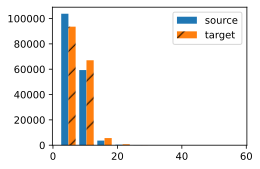

In [5]:
# Importar as bibliotecas necessárias
from d2l import torch as d2l
import matplotlib.pyplot as plt

# Definir o tamanho da figura para os gráficos
d2l.set_figsize()

# Criar o histograma das distribuições de comprimento das frases de origem (Inglês) e destino (Francês)
_, _, patches = plt.hist(
    [[len(l) for l in source], [len(l) for l in target]],
    label=['source', 'target'])

# Aplicar hachuras nas barras do histograma da língua alvo (Francês)
for patch in patches[1].patches:
    patch.set_hatch('/')

# Exibir a legenda e o gráfico
plt.legend(loc='upper right')
plt.show()


In [6]:
# Criar o vocabulário a partir das frases de origem (Inglês)
src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])

# Exibir o tamanho do vocabulário
len(src_vocab)


10012

In [7]:
# Definir a função de truncamento e preenchimento (padding)
def truncate_pad(line, num_steps, padding_token):
    """Trunca ou preenche sequências."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncar a sequência
    return line + [padding_token] * (num_steps - len(line))  # Preencher com tokens de padding

# Aplicar a função de truncamento/preenchimento à primeira frase de origem (Inglês)
# Convertendo a frase para índices do vocabulário e ajustando para um comprimento de 10
result = truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

# Exibir o resultado
result


[3919, 80, 208, 208, 208, 208, 208, 208, 208, 208]

In [8]:
import numpy as np

# Definir a função para transformar sequências de texto em minibatches
def build_array_nmt(lines, vocab, num_steps):
    """Transforma sequências de texto de tradução automática em minibatches."""
    # Converter as palavras das linhas em índices de vocabulário
    lines = [vocab[l] for l in lines]
    # Adicionar o token de fim de sequência ('<eos>') a cada linha
    lines = [l + [vocab['<eos>']] for l in lines]
    # Truncar ou preencher as sequências e transformá-las em um array NumPy
    array = np.array([truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    # Calcular o comprimento válido de cada linha (ignorar os tokens de padding)
    valid_len = (array != vocab['<pad>']).astype(np.int32).sum(1)
    return array, valid_len

# Exemplo de aplicação com as frases de origem
num_steps = 10  # Definir o número de etapas (comprimento máximo)
array, valid_len = build_array_nmt(source[:6], src_vocab, num_steps)

# Exibir o array e os comprimentos válidos
array, valid_len


(array([[3919,   80,  207,  208,  208,  208,  208,  208,  208,  208],
        [4288,   80,  207,  208,  208,  208,  208,  208,  208,  208],
        [7510,    0,  207,  208,  208,  208,  208,  208,  208,  208],
        [7510,    0,  207,  208,  208,  208,  208,  208,  208,  208],
        [9788,  210,  207,  208,  208,  208,  208,  208,  208,  208],
        [9925,    0,  207,  208,  208,  208,  208,  208,  208,  208]]),
 array([3, 3, 3, 3, 3, 3]))

# 9.5.5


In [10]:
import numpy as np
from d2l import torch as d2l
import torch
from torch.utils.data import TensorDataset, DataLoader

# Função para carregar e preparar os dados de tradução automática
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Retorna o iterador e os vocabulários do dataset de tradução automática."""

    # Pré-processar o texto
    text = preprocess_nmt(read_data_nmt())

    # Tokenizar o texto em sequências de origem (Inglês) e destino (Francês)
    source, target = tokenize_nmt(text, num_examples)

    # Criar vocabulário a partir das sequências de origem e destino
    src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])

    # Construir arrays de origem e destino usando truncamento e padding
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)

    # Convertendo para tensores PyTorch
    src_array = torch.tensor(src_array, dtype=torch.long)
    src_valid_len = torch.tensor(src_valid_len, dtype=torch.long)
    tgt_array = torch.tensor(tgt_array, dtype=torch.long)
    tgt_valid_len = torch.tensor(tgt_valid_len, dtype=torch.long)

    # Criar dataset e iterador de dados usando DataLoader
    dataset = TensorDataset(src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = DataLoader(dataset, batch_size, shuffle=True)

    return data_iter, src_vocab, tgt_vocab

# Definir parâmetros
batch_size = 64  # Tamanho do lote
num_steps = 10    # Comprimento máximo da sequência
num_examples = 600  # Número de exemplos

# Carregar os dados
data_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps, num_examples)

# Exibir o resultado
for X, X_valid_len, Y, Y_valid_len in data_iter:
    print('X:', X.shape, 'Valid length of X:', X_valid_len)
    print('Y:', Y.shape, 'Valid length of Y:', Y_valid_len)
    break


X: torch.Size([64, 10]) Valid length of X: tensor([4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 5, 4, 4, 3, 4, 4, 4, 4, 4,
        4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 4, 5,
        5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4])
Y: torch.Size([64, 10]) Valid length of Y: tensor([4, 4, 3, 3, 4, 4, 4, 3, 3, 5, 6, 4, 5, 6, 5, 7, 3, 4, 3, 3, 5, 3, 3, 3,
        4, 4, 4, 5, 4, 6, 3, 4, 4, 6, 4, 3, 4, 3, 3, 4, 5, 5, 6, 4, 3, 5, 5, 5,
        5, 4, 5, 5, 4, 5, 4, 3, 3, 5, 3, 3, 3, 4, 4, 5])


In [11]:
import numpy as np
import torch

# Função para carregar e preparar os dados de tradução automática
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Retorna o iterador e os vocabulários do dataset de tradução automática."""

    # Pré-processar o texto
    text = preprocess_nmt(read_data_nmt())

    # Tokenizar o texto em sequências de origem (Inglês) e destino (Francês)
    source, target = tokenize_nmt(text, num_examples)

    # Criar vocabulário a partir das sequências de origem e destino
    src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])

    # Construir arrays de origem e destino usando truncamento e padding
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)

    # Convertendo para tensores PyTorch
    src_array = torch.tensor(src_array, dtype=torch.long)
    src_valid_len = torch.tensor(src_valid_len, dtype=torch.long)
    tgt_array = torch.tensor(tgt_array, dtype=torch.long)
    tgt_valid_len = torch.tensor(tgt_valid_len, dtype=torch.long)

    # Criar dataset e iterador de dados usando DataLoader
    dataset = TensorDataset(src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = DataLoader(dataset, batch_size, shuffle=True)

    return data_iter, src_vocab, tgt_vocab

# Definir parâmetros
batch_size = 2  # Tamanho do lote
num_steps = 8   # Comprimento máximo da sequência

# Carregar os dados
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)

# Exibir o resultado
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.numpy().astype(np.int32))  # Convertendo para NumPy e int32
    print('Valid lengths for X:', X_valid_len.numpy())  # Convertendo para NumPy
    print('Y:', Y.numpy().astype(np.int32))  # Convertendo para NumPy e int32
    print('Valid lengths for Y:', Y_valid_len.numpy())  # Convertendo para NumPy
    break


X: [[37 12  2  4  5  5  5  5]
 [26 71  2  4  5  5  5  5]]
Valid lengths for X: [4 4]
Y: [[123  57 135   0   4   5   5   5]
 [  6   2   4   5   5   5   5   5]]
Valid lengths for Y: [5 3]
